# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image

In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


### Setting up Kaggle API to download and use datasets

In [4]:
# !pip install -q kaggle
# ! mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download shubhamgoel27/dermnet
# !unzip /content/drive/MyDrive/dermnet.zip -d /content/drive/MyDrive/dermnet

In [4]:
import os

In [5]:
test_list=os.listdir('dermnet/test') 

train_list=os.listdir('dermnet/train')

train_list.sort()
test_list.sort()

print(train_list)

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [9]:
subset_data = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos']
len(subset_data)

3

### Making Data dictionary containing image path and label

In [10]:
def data_dictionary():
    path_train="dermnet/train/"
    path_test="dermnet/test/"
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    label=0
    for i in subset_data:
        path_disease_train=path_train+i
        path_disease_test=path_test+i
        image_list_train=os.listdir(path_disease_train)
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(label)
        for m in image_list_test:
            img_path_test=path_disease_test+"/"+m
            test_dictionary["image_path"].append(img_path_test)
            test_dictionary['target'].append(label)
        label+=1 
    test_df=pd.DataFrame(test_dictionary)
    train_df=pd.DataFrame(train_dictionary)
        
    return  train_df,test_df

### Loading data and splitting it into training and testing

In [12]:
def load_data(input_size):
    xtrain_images=[]
    xtest_images=[]
    train_df,test_df=data_dictionary()
    for i in train_df['image_path']:
        # img=cv2.imread(i)
        # img=cv2.resize(img,input_size)
        # cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = load_img(i, target_size = input_size)
        img = img_to_array(img)
        xtrain_images.append(img)
    y_train=np.asarray(train_df['target'])
    x_train=np.asarray(xtrain_images)
    for j in test_df['image_path']:
        img = load_img(j, target_size = input_size)
        img = img_to_array(img)
        xtest_images.append(img)
    y_test=np.asarray(test_df['target'])
    x_test=np.asarray(xtest_images)
    return x_train,x_test,y_train,y_test

In [13]:
x_train,x_test,y_train,y_test=load_data(input_size=(224, 224))

In [28]:
# from sklearn.model_selection import train_test_split
# X_train, X_valid, Y_train, Y_valid = train_test_split(x_train,y_train, test_size = 0.1)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2464, 224, 224, 3)
(2464,)
(723, 224, 224, 3)
(723,)


In [15]:
import tensorflow as tf

In [16]:
from tensorflow.keras.utils import to_categorical
ytrain = to_categorical(y_train, 3)
ytest = to_categorical(y_test,3)

## Data Generator

In [29]:
# import time
# from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
    x_train,ytrain,
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    x_test,ytest,
    batch_size=batch_size)

In [23]:
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Sequential Model

In [24]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [16]:
x_train.shape

(2464, 224, 224, 3)

## Compliling Model


In [31]:
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)



/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training Model

In [32]:
history=model.fit(train_generator,
                            epochs=20,
                            validation_data = validation_generator,
                            verbose=1,
                            steps_per_epoch=len(x_train) // batch_size,
                            validation_steps=len(x_test) //batch_size) 
                            # callbacks=[checkpointer, learning_rate_reduction])

Epoch 1/20
77/77 [==============================] - 30s 381ms/step - loss: 1.8999 - accuracy: 0.4675 - val_loss: 0.9339 - val_accuracy: 0.5426
Epoch 2/20
77/77 [==============================] - 29s 377ms/step - loss: 0.9659 - accuracy: 0.5430 - val_loss: 0.9429 - val_accuracy: 0.5625
Epoch 3/20
77/77 [==============================] - 31s 395ms/step - loss: 0.9138 - accuracy: 0.5877 - val_loss: 0.8793 - val_accuracy: 0.5994
Epoch 4/20
77/77 [==============================] - 29s 372ms/step - loss: 0.8780 - accuracy: 0.6039 - val_loss: 0.9485 - val_accuracy: 0.5710
Epoch 5/20
77/77 [==============================] - 28s 369ms/step - loss: 0.8616 - accuracy: 0.6063 - val_loss: 0.9861 - val_accuracy: 0.5241
Epoch 6/20
77/77 [==============================] - 28s 368ms/step - loss: 0.8398 - accuracy: 0.6364 - val_loss: 1.4784 - val_accuracy: 0.4588
Epoch 7/20
77/77 [==============================] - 28s 366ms/step - loss: 0.8144 - accuracy: 0.6449 - val_loss: 0.8740 - val_accuracy: 0.6236

In [33]:
model.save("SkinDiseasePrediction.h5")

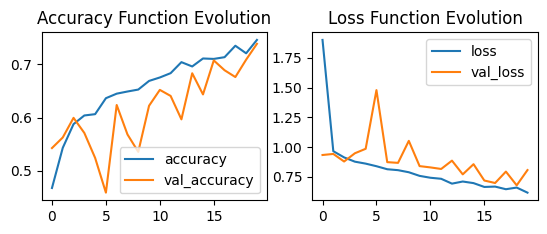

In [34]:
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss Function Evolution')
plt.legend()

In [8]:
import tensorflow as tf
modal = tf.keras.models.load_model("/content/drive/MyDrive/SkinDiseasePrediction.h5")

In [17]:

pred = modal.predict(x_test)

23/23 [==============================] - 37s 2s/step


In [19]:
from sklearn.metrics import accuracy_score
score = modal.evaluate(x_test, ytest, verbose = 0)

In [22]:
xtest = x_test/255
score1 = modal.evaluate(xtest, ytest, verbose = 0)

In [23]:
score1

[0.802291750907898, 0.7385892271995544]

## Testing 

In [ ]:
import tensorflow as tf
import numpy as np
modal = tf.keras.models.load_model("/content/drive/MyDrive/dermnet/SkinDiseasePrediction.h5")

img = load_img("/content/drive/MyDrive/dermnet/SkinTest/Acne and Rosacea.jpg", target_size = (224, 224,3))
img = img_to_array(img)
img=np.asarray(img)
img_batch = np.expand_dims(img, axis=0)
img = img/255

skin_classes = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos']

pred_index = np.argmax(modal.predict(img_batch))
pred_class=skin_classes[pred_index]
print("\nThis patient has '{}' disease.".format(pred_class))